# Dataset

In [1]:
import sys
sys.path.append('../../datasets/')
from prepare_individuals import prepare, germanBats
import matplotlib.pyplot as plt
import torch
import numpy as np
import tqdm
import pickle

classes = germanBats

In [2]:
patch_len = 44                               # 88 bei 44100, 44 bei 22050 = 250ms ~ 25ms

X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../../datasets/prepared.h5", classes, patch_len)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.56it/s]


In [3]:
with open('../call_nocall.indices', 'rb') as file:
    indices, labels = pickle.load(file)
    train_indices = indices[0]
    test_indices = indices[1]
    val_indices = indices[2]
    
    X_train = X_train[train_indices]
    X_test = X_test[test_indices]
    X_val = X_val[val_indices]
    
    Y_train = Y_train[train_indices]
    Y_test = Y_test[test_indices]
    Y_val = Y_val[val_indices]

In [4]:
print("Total calls:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total calls: 33868
(19839, 44, 257) (19839,)


In [5]:
families = np.asarray([0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 6])

Y_train = families[Y_train]
Y_test = families[Y_test]
Y_val = families[Y_val]

In [6]:
classes = {
    "Rhinolophus": 0,
    "Myotis": 1,
    "Nyctalus": 2,
    "Pipistrellus": 3,
    "Eptesicus": 4,
    "Miniopterus schreibersii": 5,
    "Vespertilio murinus": 6,
}

# Model

In [7]:
import time
import datetime
import tqdm
import torch.nn as nn
import torchvision
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader
from timm.data.mixup import Mixup

In [8]:
use_stochdepth = True
use_mixedprecision = False
use_imbalancedsampler = True
use_sampler = False
use_cosinescheduler = False
use_reduceonplateu = True
use_nadam = False
use_mixup = False

In [9]:
mixup_args = {
    'mixup_alpha': 1.,
    'cutmix_alpha': 0.,
    'cutmix_minmax': None,
    'prob': 1.0,
    'switch_prob': 0.,
    'mode': 'batch',
    'label_smoothing': 0,
    'num_classes': len(list(classes))}
mixup_fn = Mixup(**mixup_args)

In [10]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
            
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x = torchvision.ops.stochastic_depth(input=x, p=0.25, mode='batch', training=self.training)  # randomly zero input tensor
        x += identity
        x = self.relu(x)
        return x

In [11]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

In [12]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        if use_mixup:
            inputs, labels = mixup_fn(inputs, labels)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        with autocast(enabled=use_mixedprecision):
            # Forward Pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Compute Loss
            loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights
        optimizer.step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        if use_mixup:
            running_corrects += (predictions == torch.max(labels, 1)[1]).sum().item()
        else:
            running_corrects += (predictions == labels).sum().item()
        
        # Perform learning rate step
        if use_cosinescheduler:
            scheduler.step(epoch + batch / num_batches)
    
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [13]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            if use_mixup:
                labels = torch.nn.functional.one_hot(labels.to(torch.int64), num_classes=len(list(classes))).float()

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Update Weights
            # optimizer.step()

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            if use_mixup:
                running_corrects += (predictions == torch.max(labels, 1)[1]).sum().item()
            else:
                running_corrects += (predictions == labels).sum().item()

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [14]:
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data import WeightedRandomSampler

batch_size = 64
epochs = 20
lr = 0.005
warmup_epochs = 5
wd = 0.01

'''# Experiment: wrong sampling
X = np.concatenate([X_train, X_test, X_val])
Y = np.concatenate([Y_train, Y_test, Y_val])

full_data = TensorDataset(torch.Tensor(np.expand_dims(X, axis=1)), torch.from_numpy(Y))
train_size = int(0.75 * len(full_data))
test_size = len(full_data) - train_size
val_size = int(0.2 * test_size)
test_size -= val_size

train_data, test_data, val_data = torch.utils.data.random_split(full_data, [train_size, test_size, val_size],
                                                                generator=torch.Generator().manual_seed(42))'''

train_data = TensorDataset(torch.Tensor(np.expand_dims(X_train, axis=1)), torch.from_numpy(Y_train))
test_data = TensorDataset(torch.Tensor(np.expand_dims(X_test, axis=1)), torch.from_numpy(Y_test))
val_data = TensorDataset(torch.Tensor(np.expand_dims(X_val, axis=1)), torch.from_numpy(Y_val))

if use_imbalancedsampler:
    train_loader = DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data), batch_size=batch_size)
    test_loader = DataLoader(test_data, sampler=ImbalancedDatasetSampler(test_data), batch_size=batch_size)
    val_loader = DataLoader(val_data, sampler=ImbalancedDatasetSampler(val_data), batch_size=batch_size)
elif use_sampler:
    def getSampler(y):
        _, counts = np.unique(y, return_counts=True)
        weights = [len(y)/c for c in counts]
        samples_weights = [weights[t] for t in y]
        return WeightedRandomSampler(samples_weights, len(y))
    
    train_loader = DataLoader(train_data, sampler=getSampler(Y_train), batch_size=batch_size)
    test_loader = DataLoader(test_data, sampler=getSampler(Y_test), batch_size=batch_size)
    val_loader = DataLoader(val_data, sampler=getSampler(Y_val), batch_size=batch_size)
else:
    train_loader = DataLoader(train_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)

In [15]:
model = ResNet(18, Block, image_channels=1, num_classes=len(list(classes)))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)
print(device)

cuda:0


In [16]:
import wandb

wandb.init(project="BAT-baseline", entity="frankfundel")

wandb.config = {
  "learning_rate": lr,
  "epochs": epochs,
  "batch_size": batch_size
}

criterion = nn.CrossEntropyLoss()
if use_mixup:
    criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
if use_nadam:
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr, weight_decay=wd)

scheduler = None
if use_cosinescheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs, T_mult=1)
if use_reduceonplateu:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel (use `wandb login --relogin` to force relogin)


In [17]:
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc = train_epoch(model, epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)
    
    val_loss, val_acc = test_epoch(model, epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)
    
    if use_reduceonplateu:
        scheduler.step(val_loss)
    
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
         
        # Saving State Dict
        torch.save(model.state_dict(), 'baseline_families.pth')

==================== Starting at epoch 0 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:56<00:00,  5.52it/s]

Training loss: 1.6753 Acc: 0.3945



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 41.30it/s]

Validation loss: 1.3822 Acc: 0.5307
val_loss decreased, saving model


==================== Starting at epoch 1 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:57<00:00,  5.37it/s]

Training loss: 1.1541 Acc: 0.6365



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 51.25it/s]

Validation loss: 0.9125 Acc: 0.6616
val_loss decreased, saving model


==================== Starting at epoch 2 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:50<00:00,  6.14it/s]

Training loss: 0.8907 Acc: 0.7247



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 46.56it/s]

Validation loss: 0.6964 Acc: 0.7564
val_loss decreased, saving model


==================== Starting at epoch 3 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:48<00:00,  6.35it/s]

Training loss: 0.6797 Acc: 0.7943



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 53.48it/s]

Validation loss: 0.6809 Acc: 0.7674
val_loss decreased, saving model


==================== Starting at epoch 4 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:48<00:00,  6.40it/s]

Training loss: 0.5733 Acc: 0.8273



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 52.09it/s]

Validation loss: 0.5302 Acc: 0.8302
val_loss decreased, saving model


==================== Starting at epoch 5 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:51<00:00,  6.05it/s]

Training loss: 0.4976 Acc: 0.8492



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 47.15it/s]

Validation loss: 0.5203 Acc: 0.8295
val_loss decreased, saving model


==================== Starting at epoch 6 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:58<00:00,  5.29it/s]

Training loss: 0.4380 Acc: 0.8666



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 43.49it/s]

Validation loss: 0.4308 Acc: 0.8591
val_loss decreased, saving model


==================== Starting at epoch 7 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:55<00:00,  5.59it/s]

Training loss: 0.3951 Acc: 0.8835



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 48.49it/s]

Validation loss: 0.4709 Acc: 0.8418
==================== Starting at epoch 8 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:57<00:00,  5.43it/s]

Training loss: 0.3834 Acc: 0.8875



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 47.31it/s]

Validation loss: 0.4187 Acc: 0.8558
val_loss decreased, saving model


==================== Starting at epoch 9 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:59<00:00,  5.22it/s]

Training loss: 0.3496 Acc: 0.8935



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 46.07it/s]

Validation loss: 0.4192 Acc: 0.8556
==================== Starting at epoch 10 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:56<00:00,  5.48it/s]

Training loss: 0.3335 Acc: 0.9005



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 48.37it/s]

Validation loss: 0.4179 Acc: 0.8595
val_loss decreased, saving model


==================== Starting at epoch 11 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:57<00:00,  5.37it/s]

Training loss: 0.2882 Acc: 0.9144



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 46.27it/s]

Validation loss: 0.3910 Acc: 0.8691
val_loss decreased, saving model


==================== Starting at epoch 12 ====================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:56<00:00,  5.49it/s]

Training loss: 0.2646 Acc: 0.9171



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 46.98it/s]

Validation loss: 0.3948 Acc: 0.8687
==================== Starting at epoch 13 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:57<00:00,  5.42it/s]

Training loss: 0.2334 Acc: 0.9278



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 46.13it/s]

Validation loss: 0.4181 Acc: 0.8708
==================== Starting at epoch 14 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:56<00:00,  5.53it/s]

Training loss: 0.2543 Acc: 0.9246



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 42.39it/s]

Validation loss: 0.4358 Acc: 0.8787
==================== Starting at epoch 15 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:57<00:00,  5.37it/s]

Training loss: 0.2386 Acc: 0.9315



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 45.12it/s]

Validation loss: 0.4131 Acc: 0.8721
==================== Starting at epoch 16 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:55<00:00,  5.55it/s]

Training loss: 0.2285 Acc: 0.9315



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 45.75it/s]

Validation loss: 0.4071 Acc: 0.8877
==================== Starting at epoch 17 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:53<00:00,  5.80it/s]

Training loss: 0.2179 Acc: 0.9366



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 49.19it/s]

Validation loss: 0.4618 Acc: 0.8619
==================== Starting at epoch 18 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:54<00:00,  5.67it/s]

Training loss: 0.2077 Acc: 0.9398



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 48.52it/s]

Validation loss: 0.4339 Acc: 0.8687
==================== Starting at epoch 19 ====================



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:53<00:00,  5.81it/s]

Training loss: 0.1941 Acc: 0.9437



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 48.16it/s]

Validation loss: 0.4252 Acc: 0.8804


In [18]:
wandb.finish()

train_acc,▁▄▅▆▇▇▇▇▇▇▇█████████
train_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▇▇▇▇▇▇▇██████▇██
val_loss,█▅▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁
train_acc,0.94375
train_loss,0.19409
val_acc,0.88041
val_loss,0.4252


In [19]:
model.load_state_dict(torch.load('baseline_families.pth'))
compiled_model = torch.jit.script(model)
torch.jit.save(compiled_model, 'baseline_families.pt')

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    output = model(inputs.cuda()) # Feed Network

    output = (torch.max(output, 1)[1]).data.cpu().numpy()
    Y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    Y_true.extend(labels) # Save Truth

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:18<00:00,  7.39it/s]


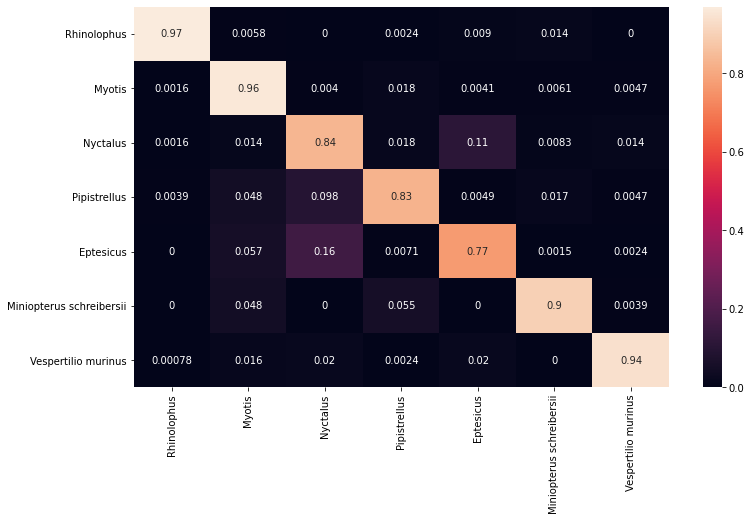

In [21]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('baseline_families_cf.png')

In [22]:
from sklearn.metrics import f1_score
corrects = np.equal(Y_pred, Y_true).sum()
print("Test accuracy:", corrects/len(Y_pred))
print("F1-score:", f1_score(Y_true, Y_pred, average=None).mean())

Test accuracy: 0.8863842319891255
F1-score: 0.8860909591954798
